# Bike sharing in Washington
<em>Group Project Statistical Programming in Python<em>
___

                                Master in Business Analytics & Big data
                                    Professor Jorge Lopez Lazaro
                                             Group D
                                            _________

In this report all useful visualizations for the stakeholder our bundled and described. The decision to keep the visualizations seperate are to make it easy for the user to run them and see the ML analysis separatly.

## Libraries to use

In [1]:
import pandas as pd
import numpy as np
import warnings

from collections import defaultdict
from sklearn import metrics

from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import (
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.svm import SVR
from sklearn import model_selection

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


warnings.simplefilter(action="ignore")

## Data Loading
The dataset can be accessed at the following website: https://www.kaggle.com/marklvl/bike-sharing-dataset.
The file is downloaded and loaded in a gist, so it can be loaded into the python script when you are conected to the internet. In addition, we found the dataset of all Bike Sharing Stations Capital Bike Sharing runs. We will run exploratory location analysis on it in order to discover patterns in the data.

In [2]:
day_data = pd.read_csv(
    "https://gist.githubusercontent.com/geraldwal/483038a2a588e29dbad6ec4e51bbb6bc/raw/152607f899f5746a1b6afa103f68052ffe3fef65/day%2520-%2520Python%2520Bike%2520Sharing",
    sep=",",
)
hour_data = pd.read_csv(
    "https://gist.githubusercontent.com/geraldwal/b5a83f4c670abe0a662abce558e5d433/raw/bce4bbfc63355606e4503964e25798b5d2190b9b/hour%2520-%2520Python%2520Bike%2520Sharing",
    sep=",",
    parse_dates=[1],
)
location_data = pd.read_csv(
    "https://gist.githubusercontent.com/geraldwal/3aba0d1a34965e2e59e1b6bf37e0bd91/raw/0266a0f936f2e1e75495d2e351090e80b49c107a/LocationsCapitalBikeStations%2520-%2520Python%2520Group",
    sep=",",
)

## Data prep

In [3]:
hour_data.rename(
    columns={
        "weathersit": "weather",
        "mnth": "month",
        "hr": "hour",
        "hum": "humidity",
        "cnt": "count",
        "yr": "year",
    },
    inplace=True,
)

To have all needed values included, we created the day column as well

In [4]:
hour_data.dteday = pd.to_datetime(hour_data.dteday, format="%Y-%m-%d")
hour_data["day"] = pd.DatetimeIndex(hour_data["dteday"]).day
display(hour_data.head(2))

,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1


When analyzing the variables further, we realized that the season column includes misleading information as shown below, therefore we adjusted it to the real, non overlapping seasons (from: https://en.wikipedia.org/wiki/Season).

In [5]:
print(hour_data.groupby("season").apply(lambda x: x["month"].unique()))

season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
dtype: object


In [6]:
hour_data["season"] = (pd.DatetimeIndex(hour_data["dteday"]).month % 12 + 3) // 3
print(hour_data.groupby("season").apply(lambda x: x["month"].unique()))

season
1     [1, 2, 12]
2      [3, 4, 5]
3      [6, 7, 8]
4    [9, 10, 11]
dtype: object


# Data Visualization

We start by plotting the seaborn integrated pairplot, which compares the hour value against all other column values. We might be able to already spot some first patterns, but we will plot more specific plots to correctly identify them.

In [7]:
date_rng = pd.date_range(start="1/1/2011", end="31/12/2012/23", freq="H")

In [8]:
series = pd.DataFrame(date_rng, columns=["date"])
series["data"] = hour_data[["count"]]
series.head(15)

,date,data
0,2011-01-01 00:00:00,16.0
1,2011-01-01 01:00:00,40.0
2,2011-01-01 02:00:00,32.0
3,2011-01-01 03:00:00,13.0
4,2011-01-01 04:00:00,1.0
5,2011-01-01 05:00:00,1.0
6,2011-01-01 06:00:00,2.0
7,2011-01-01 07:00:00,3.0
8,2011-01-01 08:00:00,8.0
9,2011-01-01 09:00:00,14.0


In [9]:
series["datetime"] = pd.to_datetime(series["date"])
series = series.set_index("datetime")
series.drop(["date"], axis=1, inplace=True)
series.head()

,data
datetime,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0


a) Time Series Plots

a-1) series.plot: Total count of bikes (registered+casual) plotted on a time series (2011-2012), with an increasing trend throughout the last 3 quarters of each year, and increasing trend year over year as well. Drop usually happens in January.

a-2) series_casual: Casual bikes (registered+casual) plotted on a time series (2011-2012), with an increasing trend throughout the last 3 quarters of each year, and increasing trend year over year as well. Drop usually happens in January.


a-3) series_registered: Registered bikes (registered+casual) plotted on a time series (2011-2012), with an increasing trend throughout the last 3 quarters of each year, and increasing trend year over year as well. Drop usually happens in January.


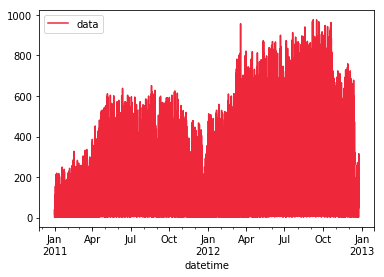

In [10]:
series.plot(color="#EE273A")
plt.show()

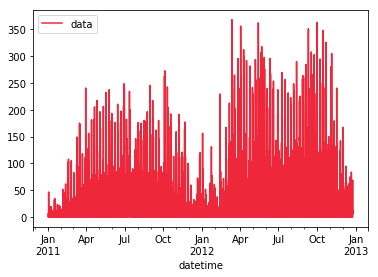

In [11]:
series_casual = pd.DataFrame(date_rng, columns=["date"])
series_casual["data"] = hour_data[["casual"]]
series_casual["datetime"] = pd.to_datetime(series_casual["date"])
series_casual = series_casual.set_index("datetime")
series_casual.drop(["date"], axis=1, inplace=True)
series_casual.plot(color="#EE273A")
plt.show()

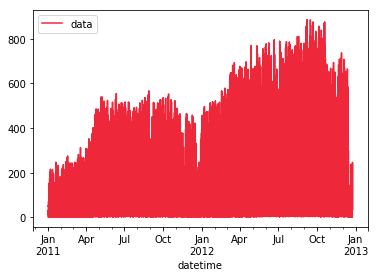

In [12]:
series_registered = pd.DataFrame(date_rng, columns=["date"])
series_registered["data"] = hour_data[["registered"]]
series_registered["datetime"] = pd.to_datetime(series_registered["date"])
series_registered = series_registered.set_index("datetime")
series_registered.drop(["date"], axis=1, inplace=True)
series_registered.plot(color="#EE273A")
plt.show()

b) Scatter Plots

b-1) Casual Bike Users vs Temperature

b-2) Casual Bike Users vs Felt Temperature

b-3) Registered Bike Users vs Temperature

b-4) Registered Bike Users vs Felt Temperature

All plots mentioned above show an increasing trend of bicycle use when the temperature is increasing (both casual and registered bikes). The drop occurs when the last 10% highest reported and felt temperatures, showing that high temperatures as well can be less attractive for bicycle users. 

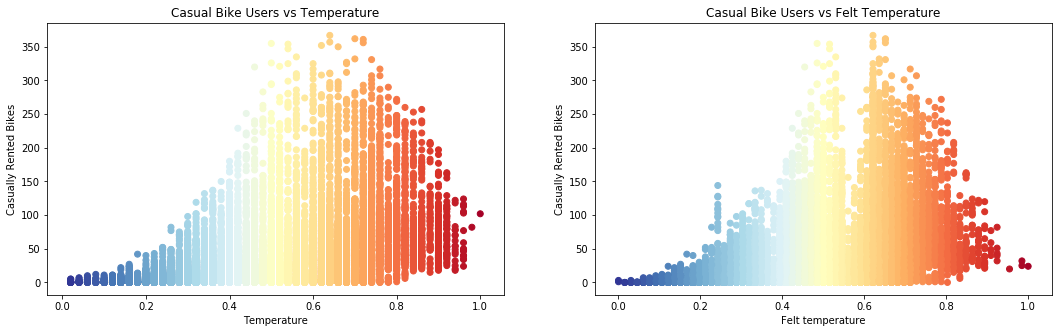

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax1 = axs[0]
ax1.scatter(
    hour_data["temp"], hour_data["casual"], c=hour_data["temp"], cmap="RdYlBu_r"
)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Casually Rented Bikes")
ax1.set_title("Casual Bike Users vs Temperature")

ax2 = axs[1]
ax2.scatter(
    hour_data["atemp"], hour_data["casual"], c=hour_data["atemp"], cmap="RdYlBu_r"
)
ax2.set_xlabel("Felt temperature")
ax2.set_ylabel("Casually Rented Bikes")
ax2.set_title("Casual Bike Users vs Felt Temperature")

plt.show()

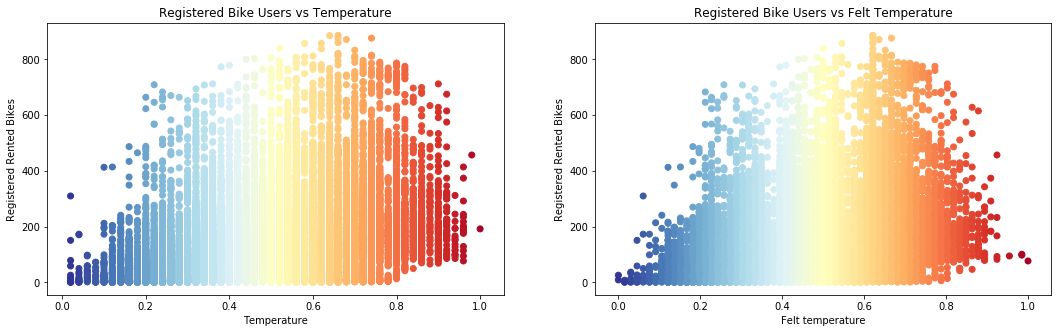

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax1 = axs[0]
ax1.scatter(
    hour_data["temp"], hour_data["registered"], c=hour_data["temp"], cmap="RdYlBu_r"
)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Registered Rented Bikes")
ax1.set_title("Registered Bike Users vs Temperature")

ax2 = axs[1]
ax2.scatter(
    hour_data["atemp"], hour_data["registered"], c=hour_data["atemp"], cmap="RdYlBu_r"
)
ax2.set_xlabel("Felt temperature")
ax2.set_ylabel("Registered Rented Bikes")
ax2.set_title("Registered Bike Users vs Felt Temperature")

plt.show()

c) Trend



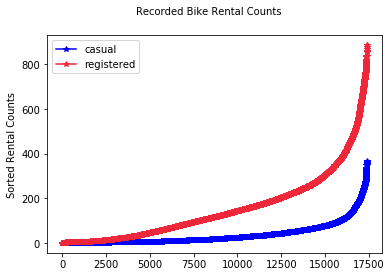

In [54]:
fig, ax = plt.subplots(1)
ax.plot(sorted(hour_data["casual"]), c="b", marker="*", label="casual")
ax.plot(sorted(hour_data["registered"]), c="#EE273A", marker="*", label="registered")
ax.legend(loc="upper left")
ax.set_ylabel("Sorted Rental Counts", fontsize=10)
fig.suptitle("Recorded Bike Rental Counts", fontsize=10)

plt.show()

d) Scatter Plots

d-1) Casual vs Windspeed

d-2) Registered vs Windspeed

Both plots mentioned above show an decreasing trend of bicycle use when the windspeed is increasing (both casual and registered bikes).  

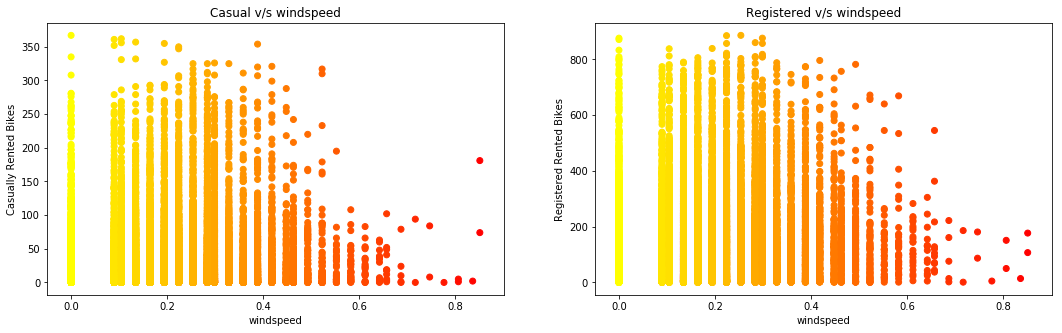

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax1 = axs[0]
ax1.scatter(
    hour_data["windspeed"],
    hour_data["casual"],
    c=hour_data["windspeed"],
    cmap="autumn_r",
)
ax1.set_xlabel("windspeed")
ax1.set_ylabel("Casually Rented Bikes")
ax1.set_title("Casual v/s windspeed")

ax2 = axs[1]
ax2.scatter(
    hour_data["windspeed"],
    hour_data["registered"],
    c=hour_data["windspeed"],
    cmap="autumn_r",
)
ax2.set_xlabel("windspeed")
ax2.set_ylabel("Registered Rented Bikes")
ax2.set_title("Registered v/s windspeed")

plt.show()

e) Scatter Plots

e-1) Registered vs Humidity: Registered bikes use decrease as humidity increases.

e-2) Casual vs Humidity: Casual bikes use is steady even when humidity increases.

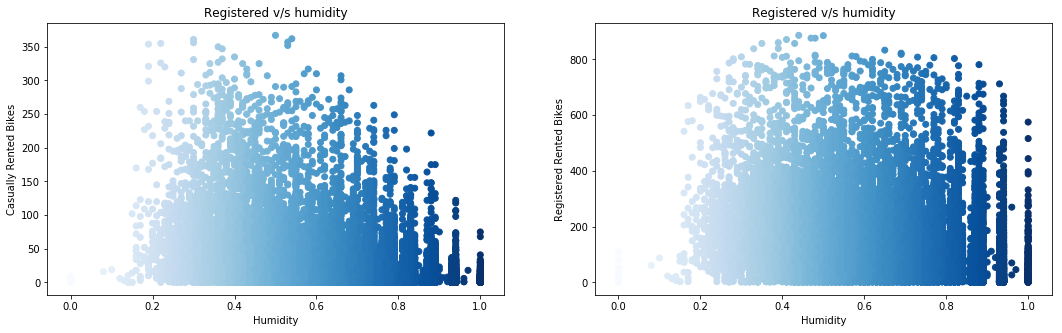

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax1 = axs[0]
ax1.scatter(
    hour_data["humidity"], hour_data["casual"], c=hour_data["humidity"], cmap="Blues"
)
ax1.set_xlabel("Humidity")
ax1.set_ylabel("Casually Rented Bikes")
ax1.set_title("Casual v/s humidity")

ax2 = axs[1]
ax2.scatter(
    hour_data["humidity"],
    hour_data["registered"],
    c=hour_data["humidity"],
    cmap="Blues",
)
ax2.set_xlabel("Humidity")
ax2.set_ylabel("Registered Rented Bikes")
ax2.set_title("Registered v/s humidity")

plt.show()

f) Bar Chart

f-1) Total Casual Bikes Rentals per Daily Hour: Increasing trend in bikes rental after 7am, decrease starts after 6pm.

f-2) Total Registered Bikes Rentals per Daily Hour: Increasing trend in bikes rental after 6am, decrease starts after 8pm.

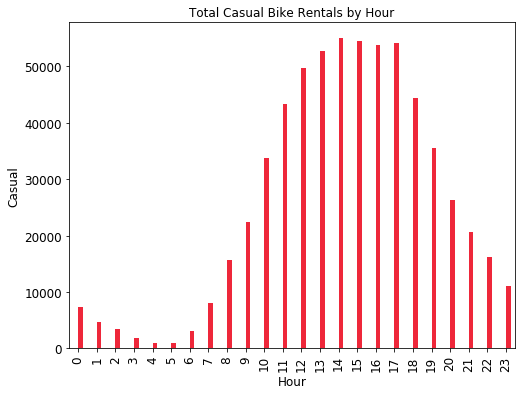

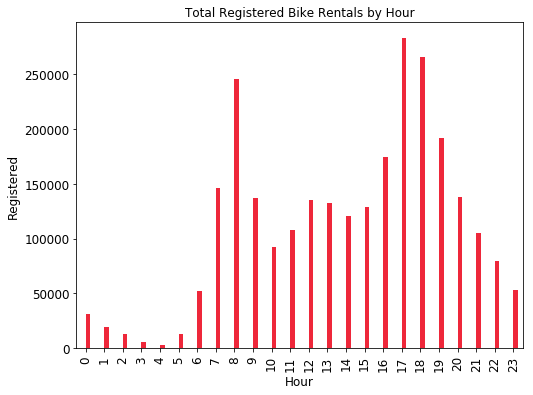

In [27]:
ax1 = (
    hour_data[["hour", "casual"]]
    .groupby(["hour"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        figsize=(8, 6),
        legend=False,
        title="Total Casual Bike Rentals by Hour",
        color="#EE273A",
        fontsize=12,
    )
)
ax1.set_xlabel("Hour", fontsize=12)
ax1.set_ylabel("Casual", fontsize=12)

ax2 = (
    hour_data[["hour", "registered"]]
    .groupby(["hour"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        figsize=(8, 6),
        legend=False,
        title="Total Registered Bike Rentals by Hour",
        color="#EE273A",
        fontsize=12,
    )
)
ax2.set_xlabel("Hour", fontsize=12)
ax2.set_ylabel("Registered", fontsize=12)

plt.show()

g) Bar Charts

g-1) Bike Rentals by Season: Highest number of casual bikes rented in fall, followed by summer and winter respectively. 

g-2) Bike Rentals by Weathersit: Highest number of casual bikes renter during clear weathersit.

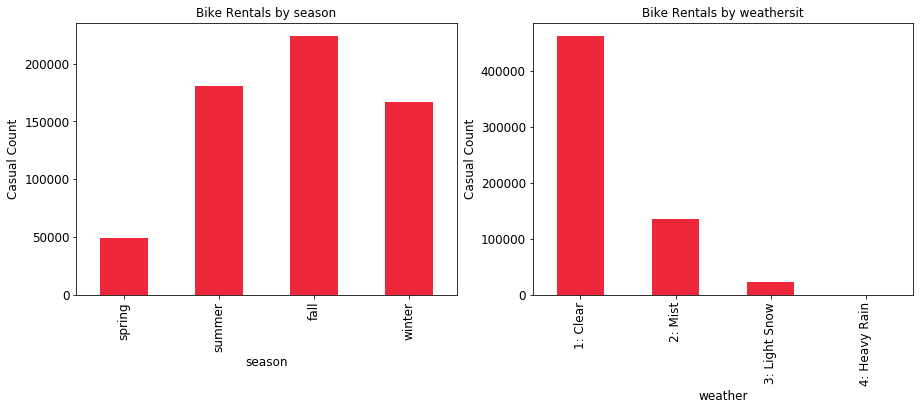

In [28]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1 = (
    hour_data[["season", "casual"]]
    .groupby(["season"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        title="Bike Rentals by season",
        stacked=True,
        fontsize=12,
        ax=ax1,
        color="#EE273A",
    )
)
ax1.set_xlabel("season", fontsize=12)
ax1.set_ylabel("Casual Count", fontsize=12)
ax1.set_xticklabels(["spring", "summer", "fall", "winter"])


ax2 = (
    hour_data[["weather", "casual"]]
    .groupby(["weather"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        stacked=True,
        title="Bike Rentals by weathersit",
        fontsize=12,
        ax=ax2,
        color="#EE273A",
    )
)

ax2.set_xlabel("weather", fontsize=12)
ax2.set_ylabel("Casual Count", fontsize=12)
ax2.set_xticklabels(["1: Clear", "2: Mist", "3: Light Snow", "4: Heavy Rain"])

f.tight_layout
plt.show()

h) Histograms

Number of casual bikes rented per season: Both graphs compare bike rental per season during year 1 and year 2, showing fall is the season with higher number of casual bikes rentals. The season with lowest rentals is spring.

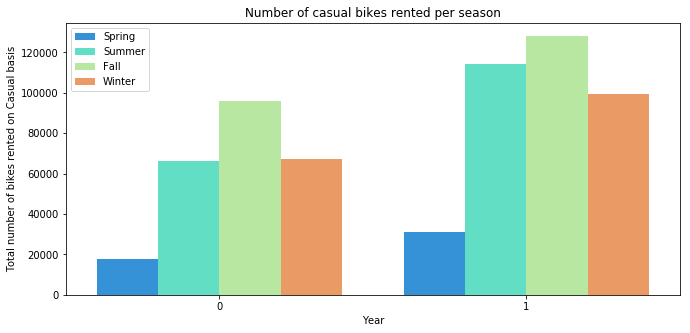

In [29]:
plt.figure(figsize=(11, 5))
sns.barplot(
    "year",
    "casual",
    hue="season",
    data=hour_data,
    palette="rainbow",
    ci=None,
    estimator=sum,
)
plt.legend(["Spring", "Summer", "Fall", "Winter"], loc="upper left")
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on Casual basis")
plt.title("Number of casual bikes rented per season")

plt.show()

i) Histograms

Number of registered bikes rented per season: Both graphs compare registered bike rental per season during year 1 and year 2, showing fall is the season with higher number of casual bikes rentals. The season with lowest rentals is spring.

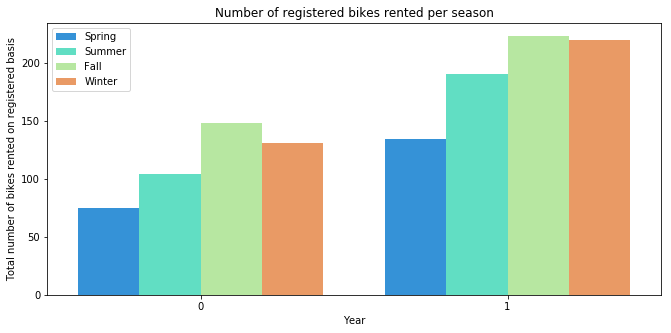

In [30]:
plt.figure(figsize=(11, 5))
sns.barplot(
    "year", "registered", hue="season", data=hour_data, palette="rainbow", ci=None
)
plt.legend(["Spring", "Summer", "Fall", "Winter"], loc="upper left")
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on registered basis")
plt.title("Number of registered bikes rented per season")


plt.show()

j) Correlation Matrix: Highly correlated variables are:

Windspeed and humidity
Casual and humidity
Registered and humidity
Count and humidity

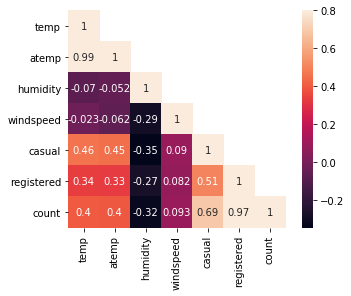

In [31]:
corrMatt = hour_data[
    ["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"]
].corr()

mask = np.array(corrMatt)
# Turning the lower-triangle of the array to false
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True, ax=ax)

plt.show()

j) Correlation Matrix: Highly correlated variables are:

Count and registered
Year and Instant
Count and casual

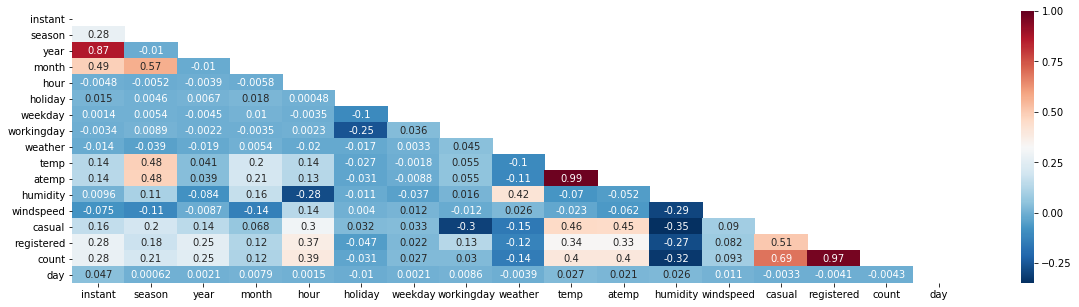

In [32]:
plt.figure(figsize=(20, 5))
mask = np.zeros_like(hour_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hour_data.corr(), cmap="RdBu_r", mask=mask, annot=True)

plt.show()

l) Bar Charts

l-1) Monthly Distribution (Registered)

l-2) Monthly Distribution (Casual)

Months with highest number of rentals (casual and registered) are May to October, yearly decrease starts in November.

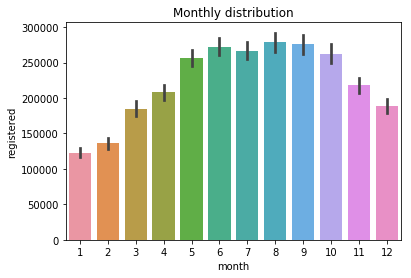

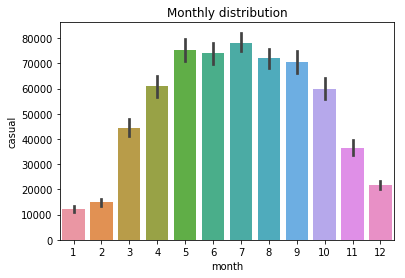

In [34]:
fig, ax = plt.subplots()
sns.barplot(
    data=hour_data[["month", "registered"]],
    x="month",
    y="registered",
    ax=ax,
    estimator=sum,
)
ax.set(title="Monthly distribution")

fig, ax = plt.subplots()
sns.barplot(
    data=hour_data[["month", "casual"]], x="month", y="casual", ax=ax, estimator=sum
)
ax.set(title="Monthly distribution")

plt.show()

m) sns.Pointplots

m-1) Use of the system by total users; hourly distribution, split to weekdays: Show peak hours at 8am and 5pm, office hours.

m-2) Use of the system by casual users; hourly distribution, split to weekdays: Show most activity between 9am and 8pm.

m-3) Use of the system by registered users; hourly distribution, split to weekdays: Show peak hours at 8am and 5pm, office hours.

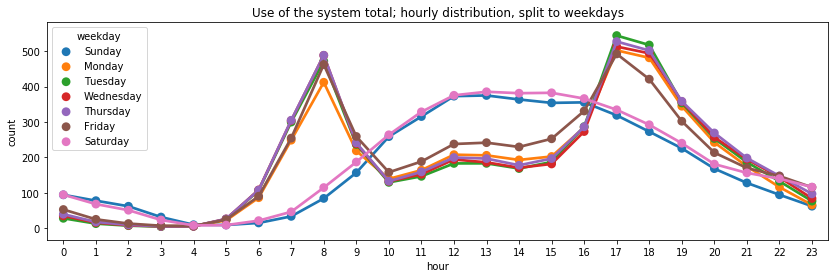

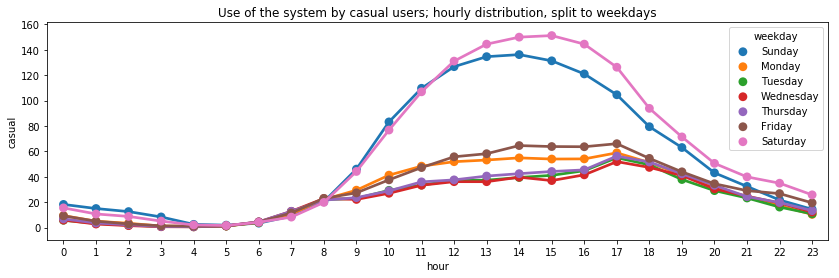

weekdays- no real peaks, increase within the day. weekends- peaks are during the day


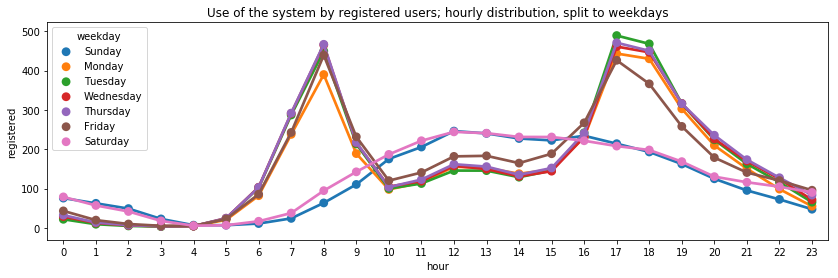

weekdays- peaks are mornings and evenings. weekends- peaks are during the day, nearly similar to count


In [36]:
plt.figure(figsize=(14, 4))
weekday_hr_gb = (
    hour_data.groupby(["weekday", "hour"]).mean()["count"].reset_index(drop=False)
)
g = sns.pointplot(x="hour", y="count", hue="weekday", data=weekday_hr_gb)
g_legend = g.axes.get_legend()
g_labels = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.title("Use of the system total; hourly distribution, split to weekdays")
plt.show()
# print ('weekdays- peaks are mornings and evenings. weekends- peaks are during the day')

plt.figure(figsize=(14, 4))
weekday_hr_gb = (
    hour_data.groupby(["weekday", "hour"]).mean()["casual"].reset_index(drop=False)
)
g = sns.pointplot(x="hour", y="casual", hue="weekday", data=weekday_hr_gb)
g_legend = g.axes.get_legend()
g_labels = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.title("Use of the system by casual users; hourly distribution, split to weekdays")
plt.show()
print(
    "weekdays- no real peaks, increase within the day. weekends- peaks are during the day"
)

plt.figure(figsize=(14, 4))
weekday_hr_gb = (
    hour_data.groupby(["weekday", "hour"]).mean()["registered"].reset_index(drop=False)
)
g = sns.pointplot(x="hour", y="registered", hue="weekday", data=weekday_hr_gb)
g_legend = g.axes.get_legend()
g_labels = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.title(
    "Use of the system by registered users; hourly distribution, split to weekdays"
)
plt.show()
print(
    "weekdays- peaks are mornings and evenings. weekends- peaks are during the day, nearly similar to count"
)

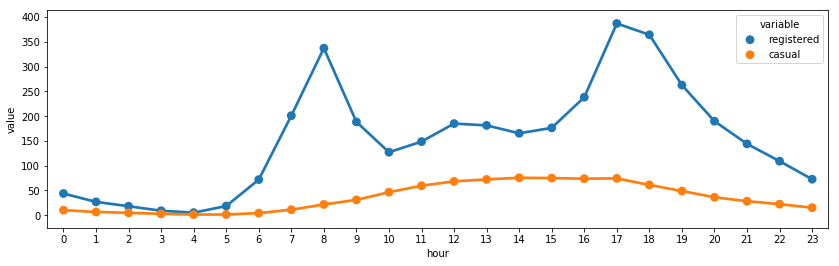

In [37]:
plt.figure(figsize=(14, 4))
hourTransformed = pd.melt(
    hour_data[["hour", "casual", "registered"]],
    id_vars=["hour"],
    value_vars=["casual", "registered"],
)
hourAggregated = pd.DataFrame(
    hourTransformed.groupby(["hour", "variable"], sort=True)["value"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["value"],
    hue=hourAggregated["variable"],
    hue_order=["registered", "casual"],
    data=hourAggregated,
    join=True,
)

plt.show()

In [38]:
hour_data["Hum_WS"] = (hour_data["humidity"] + hour_data["windspeed"]) / 2

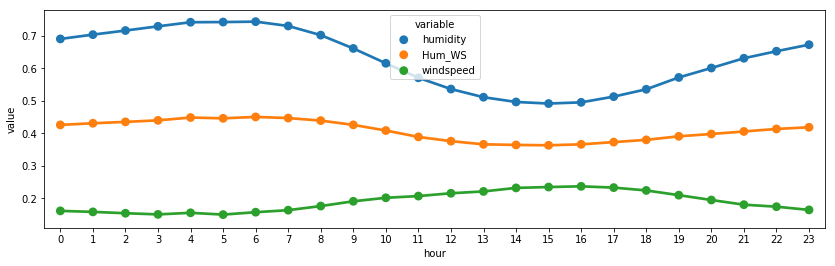

In [39]:
plt.figure(figsize=(14, 4))
HUM_WS = pd.melt(
    hour_data[["hour", "humidity", "windspeed", "Hum_WS"]],
    id_vars=["hour"],
    value_vars=["humidity", "windspeed", "Hum_WS"],
)
HUM_WSAggregated = pd.DataFrame(
    HUM_WS.groupby(["hour", "variable"], sort=True)["value"].mean()
).reset_index()
sns.pointplot(
    x=HUM_WSAggregated["hour"],
    y=HUM_WSAggregated["value"],
    hue=HUM_WSAggregated["variable"],
    hue_order=["humidity", "Hum_WS", "windspeed"],
    data=hourAggregated,
    join=True,
)

plt.show()

n) Histograms

n-1) Humidity Histogram and n-2) Humidity Histogram with quantiles: Frequency increases as humidity increases

n-3) Temperature Histogram and n-4) Temperature Histogram with quantiles: Frequency increases in second and third quantiles, and decrease starts on fourth quantile

n-5) Felt Temperature Histogram and n-6) Felt Temperature Histogram with quantiles: Frequency increases in second and third quantiles, and decrease starts on fourth quantile

n-7) Windspeed Histogram and n-8) Windspeed Histogram with quantiles: Increase in first quantile, and subtle decrease until fourth quantile.


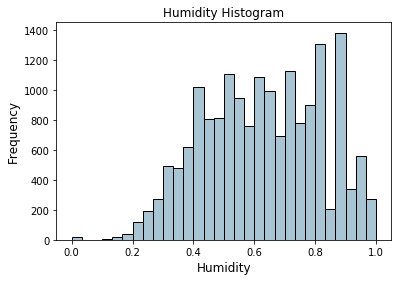

In [40]:
quantile_list = [0, 0.25, 0.5, 0.75, 1.0]

fig, ax = plt.subplots()
hour_data["humidity"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
ax.set_title("Humidity Histogram", fontsize=12)
ax.set_xlabel("Humidity", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

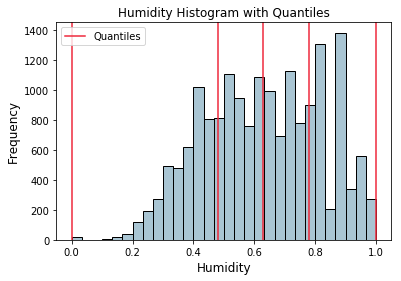

In [55]:
quantiles = hour_data["humidity"].quantile(quantile_list)

fig, ax = plt.subplots()
hour_data["humidity"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color="#EE273A")
ax.legend([qvl], ["Quantiles"], fontsize=10)
ax.set_title("Humidity Histogram with Quantiles", fontsize=12)
ax.set_xlabel("Humidity", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

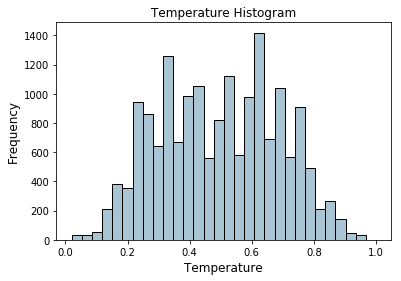

In [42]:
fig, ax = plt.subplots()
hour_data["temp"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
ax.set_title("Temperature Histogram", fontsize=12)
ax.set_xlabel("Temperature", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

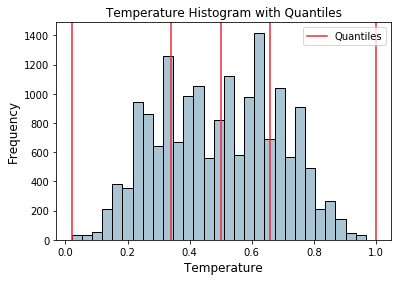

In [56]:
quantiles = hour_data["temp"].quantile(quantile_list)

fig, ax = plt.subplots()
hour_data["temp"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color="#EE273A")
ax.legend([qvl], ["Quantiles"], fontsize=10)
ax.set_title("Temperature Histogram with Quantiles", fontsize=12)
ax.set_xlabel("Temperature", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

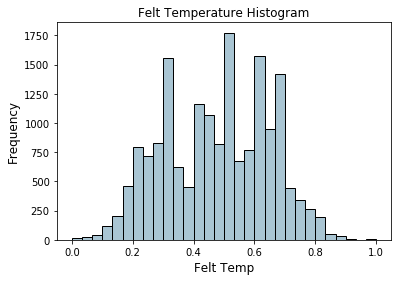

In [44]:
fig, ax = plt.subplots()
hour_data["atemp"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
ax.set_title("Felt Temperature Histogram", fontsize=12)
ax.set_xlabel("Felt Temp", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

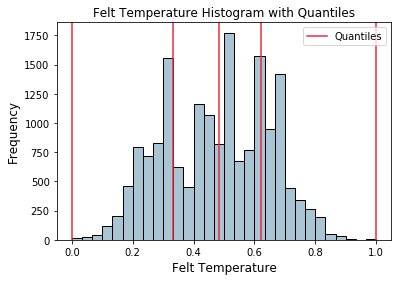

In [57]:
quantiles = hour_data["atemp"].quantile(quantile_list)

fig, ax = plt.subplots()
hour_data["atemp"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color="#EE273A")
ax.legend([qvl], ["Quantiles"], fontsize=10)
ax.set_title("Felt Temperature Histogram with Quantiles", fontsize=12)
ax.set_xlabel("Felt Temperature", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

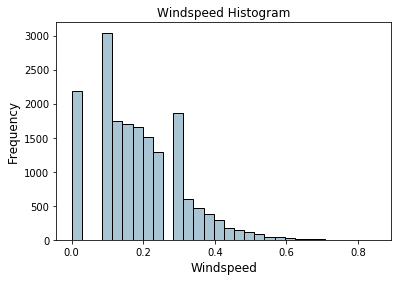

In [46]:
fig, ax = plt.subplots()
hour_data["windspeed"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
ax.set_title("Windspeed Histogram", fontsize=12)
ax.set_xlabel("Windspeed", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

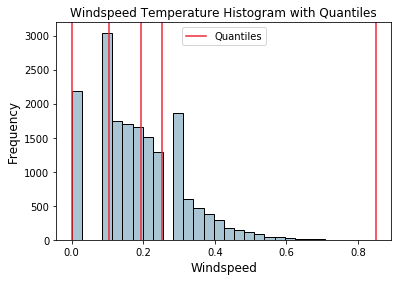

In [58]:
quantiles = hour_data["windspeed"].quantile(quantile_list)

fig, ax = plt.subplots()
hour_data["windspeed"].hist(bins=30, color="#A9C5D3", edgecolor="black", grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color="#EE273A")
ax.legend([qvl], ["Quantiles"], fontsize=10)
ax.set_title("Windspeed Temperature Histogram with Quantiles", fontsize=12)
ax.set_xlabel("Windspeed", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.show()

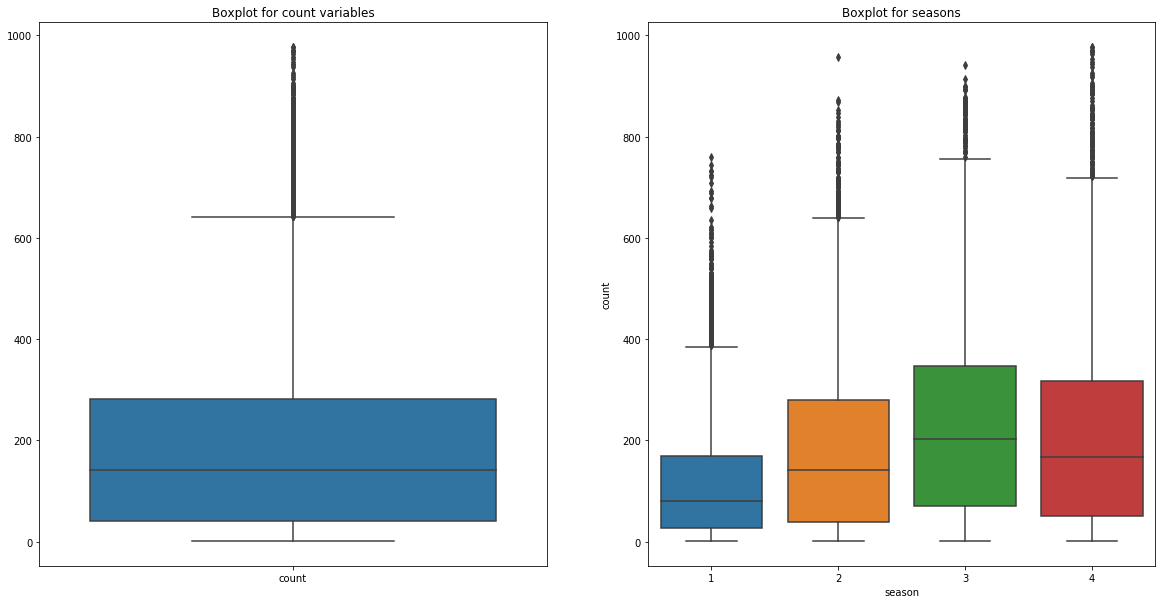

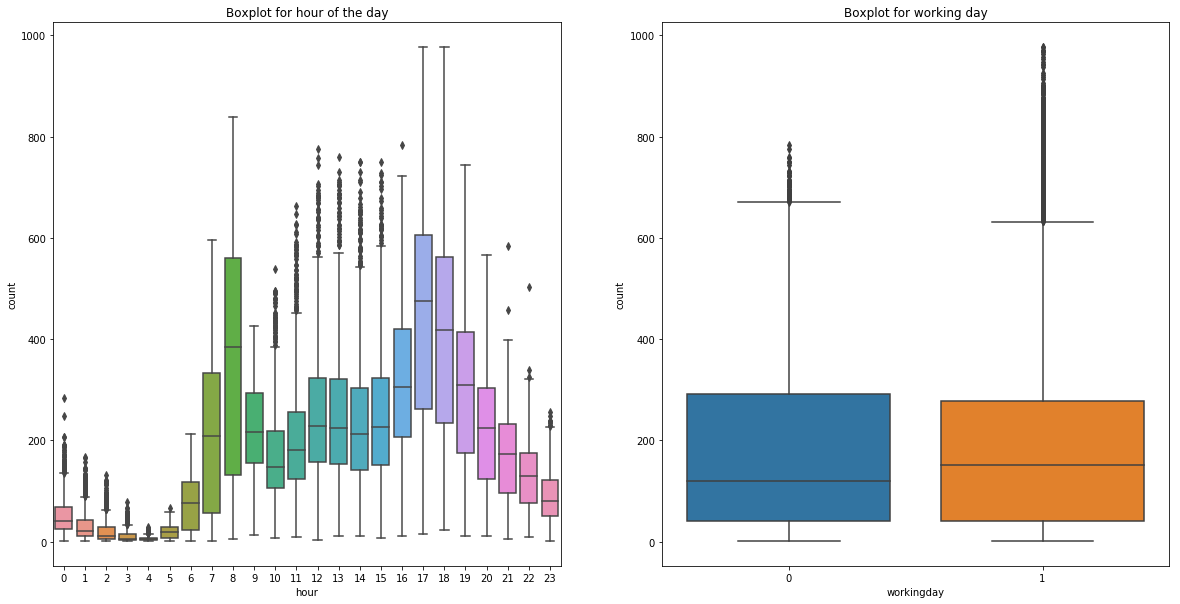

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.boxplot(data=hour_data[["count"]], ax=ax1)
ax1.set(title="Boxplot for count variables")
sns.boxplot(x=hour_data["season"], y=hour_data["count"], ax=ax2)
ax2.set(title="Boxplot for seasons")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
ax1.set(title="Boxplot for hour of the day")
sns.boxplot(x=hour_data["hour"], y=hour_data["count"], ax=ax1)
ax2.set(title="Boxplot for working day")
sns.boxplot(x=hour_data["workingday"], y=hour_data["count"], ax=ax2)

plt.show()